<a href="https://colab.research.google.com/github/sanjay7178/DL4CV/blob/main/DL4CV_Prog_Assignment6_Week11_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

def set_seed(seed_value):
    # Set Python's built-in random seed
    random.seed(seed_value)

    # Set NumPy seed
    np.random.seed(seed_value)

    # Set PyTorch seed for CPU
    torch.manual_seed(seed_value)

    # If using GPU, set the seed for the GPU as well
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # For multi-GPU setups

    # Ensure that PyTorch uses deterministic algorithms (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed set to {seed_value}")


##### VAE Encoder

In [2]:
set_seed(2024)
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEEncoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):

        # YOUR CODE STARTS HERE

        # fc1 layer output (Apply relu on top of it)
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        log_var = self.fc2_log_var(h)

        # YOUR CODE ENDS HERE

        return mu, log_var


    def reparameterize(self, mu, log_var):

        # YOUR CODE STARTS HERE
        # Compute standard deviation
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std
        # YOUR CODE ENDS HERE




# Sample input
input_dim = 28*28
hidden_dim = 256
latent_dim = 2
x = torch.randn((1, input_dim))

encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)

# YOUR CODE STARTS HERE
mu, log_var = encoder(x)
z = encoder.reparameterize(mu, log_var)
# YOUR CODE ENDS HERE


print(f"mu: {mu}\nlog_var: {log_var}\nz: {z}")


Seed set to 2024
mu: tensor([[0.0751, 0.3391]], grad_fn=<AddmmBackward0>)
log_var: tensor([[0.1880, 0.0895]], grad_fn=<AddmmBackward0>)
z: tensor([[-1.1450,  1.5405]], grad_fn=<AddBackward0>)


**Q1. What is the value of z? (Select the closest option)** \\
a) z = [[-1.1450,  1.5405]] \\
b) z = [[-1.2653,  1.5955]] \\
c) z = [[-0.0293,  0.3905]] \\
d) z = [[-0.1337,  0.4419]] \\

##### VAE Decoder

In [3]:
set_seed(2024)
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAEDecoder, self).__init__()
        # YOUR CODE STARTS HERE

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # YOUR CODE ENDS HERE

    def forward(self, z):
        # YOUR CODE STARTS HERE

        # fc1 layer output (Use relu)
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))

        # YOUR CODE ENDS HERE
        return x_recon


decoder = VAEDecoder(latent_dim, hidden_dim, input_dim)
x_recon = decoder(z)

print(f"x_recon: {torch.mean(x_recon)}")


Seed set to 2024
x_recon: 0.4945041239261627


**Q2. What is the value of mean of x_recon? (Select the closest option)** \\
a) 0.1 \\
b) -0.1 \\
c) 0.5 \\
d) -0.5 \\

##### GAN Loss

In [4]:
set_seed(2024)

# Binary Cross Entropy Loss for GANs
adversarial_loss = nn.BCELoss()

# Discriminator loss for real and fake data
def discriminator_loss(real_preds, real_labels, fake_preds, fake_labels):

    # Loss for real images
    real_loss = adversarial_loss(real_preds, real_labels)
    # Loss for fake images
    fake_loss = adversarial_loss(fake_preds, fake_labels)
    # Total loss
    total_loss = real_loss + fake_loss
    return total_loss


# Generator loss
def generator_loss(fake_preds, real_labels):
    # We want the generator to fool the discriminator, so use real_labels
    return adversarial_loss(fake_preds, real_labels)

# Example usage:
batch_size = 64
real_preds = torch.rand(batch_size, 1)
fake_preds = torch.rand(batch_size, 1)

# Real labels: 1 for real data, 0 for fake data
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

# Discriminator loss
d_loss = discriminator_loss(real_preds, real_labels, fake_preds, fake_labels)
print(f"Discriminator Loss: {d_loss.item()}")

# Generator loss: we want the fake data to be classified as real (label=1)
g_loss = generator_loss(fake_preds, real_labels)
print(f"Generator Loss: {g_loss.item()}")


Seed set to 2024
Discriminator Loss: 1.784824013710022
Generator Loss: 1.0184342861175537


**Q3. Which of the following is true?** \\
a) Generator Loss = Discriminator loss \\
b) Generator loss < Discriminator loss \\
c) Generator loss > Discriminator loss \\

##### DDPM Schedule

Seed set to 2024


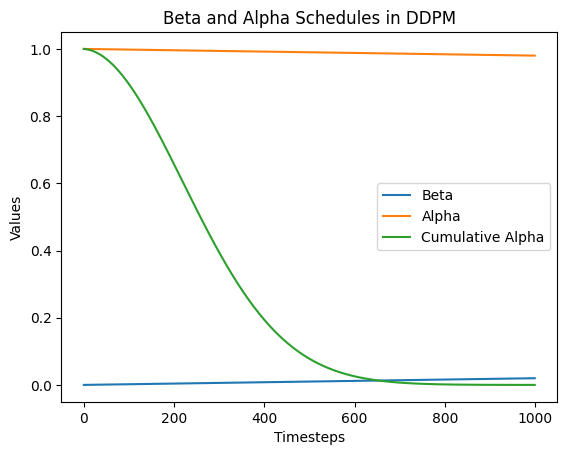

Beta[0]: tensor(1.0000e-04)
Alpha[500]: tensor(0.9899)
Alpha Cumulative Product at Timestep 999: 4.035830352222547e-05


In [8]:
set_seed(2024)
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def calculate_alpha_schedule(betas):
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return alphas, alphas_cumprod



# Parameters
timesteps = 1000
betas = linear_beta_schedule(timesteps)
alphas, alphas_cumprod = calculate_alpha_schedule(betas)

# Plotting the results
plt.plot(range(timesteps), betas, label="Beta")
plt.plot(range(timesteps), alphas, label="Alpha")
plt.plot(range(timesteps), alphas_cumprod, label="Cumulative Alpha")
plt.legend()
plt.title("Beta and Alpha Schedules in DDPM")
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.show()

# Output some specific values for MCQ
print("Beta[0]:", betas[0])
print("Alpha[500]:", alphas[500])
print("Alpha Cumulative Product at Timestep 999:", alphas_cumprod[-1].item())


**Q4. What is the value of Alpha Cumulative Product at Timestep 999? (Select the closest value)** \\
a) 10^-1 \\
b) 10^-3 \\
c) 10^-5 \\
d) 10^-7 \\


##### DDPM Forward Process

Seed set to 2024


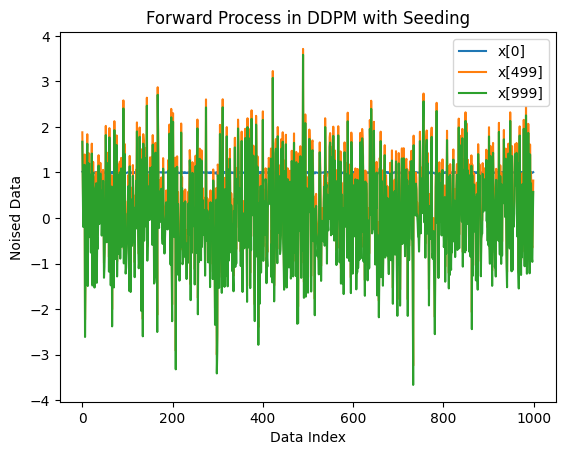

Beta[0]: tensor(1.0000e-04)
Alpha[500]: tensor(0.9899)
Alpha Cumulative Product at Timestep 999: tensor(4.0358e-05)
x[0][500]: tensor(0.9835, dtype=torch.float64)
x[500][500]: tensor(-1.3030, dtype=torch.float64)
x[999][500]: tensor(-1.6409, dtype=torch.float64)


In [6]:
set_seed(2024)


# # Linear Beta Schedule Function
# def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
#     """
#     Linearly increases beta from `start` to `end` over `timesteps`.
#     """
#     # YOUR CODE STARTS HERE
#     return ____
#     # YOUR CODE ENDS HERE

# # Calculate Alpha Schedule
# def calculate_alpha_schedule(betas):
#     """
#     Calculates the alpha schedule based on betas.
#     """
#     # YOUR CODE STARTS HERE
#     alphas = ____
#     alphas_cumprod = ____
#     # YOUR CODE ENDS HERE
#     return alphas, alphas_cumprod


# Forward Process
def forward_process(x0, timesteps, betas, alphas_cumprod):
    """
    Simulates the forward process by adding noise to the input data `x0` over `timesteps`.
    x0: original data (e.g., an image or vector)
    timesteps: number of diffusion steps
    betas: beta schedule
    alphas_cumprod: cumulative product of alphas used for variance scheduling
    """
    noise = np.random.randn(*x0.shape)
    xt = []
    for t in range(timesteps):
        mean = np.sqrt(alphas_cumprod[t]) * x0
        var = 1 - alphas_cumprod[t]
        xt.append(mean + np.sqrt(var) * noise)
    return xt

# Parameters
timesteps = 1000
betas = linear_beta_schedule(timesteps)
alphas, alphas_cumprod = calculate_alpha_schedule(betas)

# Original data x0 (e.g., a 1D signal or image)
x0 = np.ones((1000,))  # Simplified as an array of ones for visualization

# Simulate the forward process
xt = forward_process(x0, timesteps, betas, alphas_cumprod)

# Plot x_t for a few time steps
plt.plot(xt[0], label="x[0]")
plt.plot(xt[499], label="x[499]")
plt.plot(xt[-1], label="x[999]")
plt.legend()
plt.title("Forward Process in DDPM with Seeding")
plt.xlabel("Data Index")
plt.ylabel("Noised Data")
plt.show()

# Output some specific values for MCQ
print("Beta[0]:", betas[0])
print("Alpha[500]:", alphas[500])
print("Alpha Cumulative Product at Timestep 999:", alphas_cumprod[-1])
print("x[0][500]:", xt[0][500])  # Value of x at index 500 for timestep 0
print("x[500][500]:", xt[500][500])  # Value of x at index 500 for timestep 0
print("x[999][500]:", xt[-1][500])  # Value of x at index 500 for timestep 999


**Q5. What is the value for x[999][500]?(Select the closest value)** \\
a) 1.5 \\
b) -1.5 \\
c) 2.5 \\
d) -2.5 \\


**Q6. What is the mean at last time step of Forward process?(Select the closest value)** \\
a) 0 \\
b) 0.25 \\
c) 0.5 \\
d) 1 \\